# Titanic Dataset Kaggle Competition
#### Farahana, 6/8/2020

1. Problem: Predict the survived people on-board. 
2. Target : To get 90% above accuracy when submitted to the board.
3. Data   : Training set with given survived people and Test set with unknown survival.

Resources: [Youtube video ](https://www.youtube.com/watch?v=irHhDMbw3xo), [Code 1](https://github.com/justmarkham/scikit-learn-videos/blob/master/10_categorical_features.ipynb), [Code 2](https://github.com/mrdbourke/your-first-kaggle-submission/blob/master/kaggle-titanic-dataset-example-submission-workflow.ipynb), [Code 3](https://github.com/minsuk-heo/kaggle-titanic/blob/master/titanic-solution.ipynb)

In [62]:
# import essential packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Input train and validation data files
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Let us do simple EDA. Check the shape, info, missing values and type of features. 

In [3]:
train_data.shape

(891, 12)

In [4]:
test_data.shape

(418, 11)

In [5]:
print(train_data.columns)
print(test_data.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
train_data.isna().sum()
# checking missing data

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Get the non-missing value of embarked for 
train_3feature = train_data.loc[train_data.Embarked.notna(), ['Survived', 'Pclass', 'Sex', 'Embarked']]

In [8]:
train_3feature.shape

(889, 4)

In [9]:
train_3feature.isna().sum()

Survived    0
Pclass      0
Sex         0
Embarked    0
dtype: int64

In [10]:
train_3feature.head()

Survived  Pclass     Sex Embarked
0         0       3    male        S
1         1       1  female        C
2         1       3  female        S
3         1       1  female        S
4         0       3    male        S

Let us classify with common machine learning, Logistic Regression with cross-validation.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [12]:
X = train_3feature.loc[:, ['Pclass']] #to make 2D data
y = train_3feature.Survived

In [13]:
logreg = LogisticRegression(solver='lbfgs')
print(cross_val_score (logreg, X, y, cv=5, scoring='accuracy'))

[0.6011236  0.6741573  0.6741573  0.71910112 0.72316384]


In [14]:
y.value_counts(normalize=True)

0    0.617548
1    0.382452
Name: Survived, dtype: float64

Encode the non-numeric data such as 'Sex' and 'Embarked'.

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoderSex = OneHotEncoder(sparse=False)
encoderSex.fit_transform(train_3feature[['Sex']])

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [16]:
encoderSex.categories_

[array(['female', 'male'], dtype=object)]

Let us try with 3 features,

In [17]:
# let us drop 'Survived' column to make use of column transformer
X = train_3feature.drop('Survived', axis='columns')

In [18]:
from sklearn.compose import make_column_transformer 
## use this when few columns need preprocessing such as onehotencoder above.

column_trans = make_column_transformer((OneHotEncoder(), ['Sex', 'Embarked']), remainder='passthrough')
# remainder column such as 'Pclass' will retain it values.

In [19]:
column_trans.fit_transform(X) # Sex(2), Embarked(3), Pclass(1)

array([[0., 1., 0., 0., 1., 3.],
       [1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 1., 3.],
       ...,
       [1., 0., 0., 0., 1., 3.],
       [0., 1., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 3.]])

Let us try to use pipeline now.

In [20]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(column_trans, logreg)

In [21]:
cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
# this will split the data and use the pipeline.

array([0.76404494, 0.79213483, 0.76966292, 0.75280899, 0.78531073])

In [22]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('logisticregression', LogisticRegression())])

let us try to fit with different machine learning algorithms.

In [23]:
import time, datetime

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [24]:
def fit_ml_algo (algo):
    pipe = make_pipeline(column_trans, algo)
    acc = cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()
    return acc

#### KNN

In [25]:
start_time = time.time()
acc_algo = fit_ml_algo(KNeighborsClassifier(n_neighbors=5))

algo_time = (time.time() - start_time)
print ("Mean accuracy :{:.3f}".format(acc_algo))
print ("Duration      :{:.3f} sec".format(algo_time))

Mean accuracy :0.773
Duration      :0.047 sec


#### Gaussian Naive Bayes

In [26]:
start_time = time.time()
acc_algo = fit_ml_algo(GaussianNB())

algo_time = (time.time() - start_time)
print ("Mean accuracy :{:.3f}".format(acc_algo))
print ("Duration      :{:.3f} sec".format(algo_time))

Mean accuracy :0.775
Duration      :0.022 sec


#### Linear SVM

In [27]:
start_time = time.time()
acc_svc = fit_ml_algo(LinearSVC())

algo_time = (time.time() - start_time)
print ("Mean accuracy :{:.3f}".format(acc_svc))
print ("Duration      :{:.3f} sec".format(algo_time))

Mean accuracy :0.776
Duration      :0.049 sec


#### Boosting Classifier

In [28]:
start_time = time.time()
acc_boost = fit_ml_algo(GradientBoostingClassifier())

algo_time = (time.time() - start_time)
print ("Mean accuracy :{:.3f}".format(acc_boost))
print ("Duration      :{:.3f} sec".format(algo_time))

Mean accuracy :0.811
Duration      :0.239 sec


Boosting classifier has the best accuracy for now with the 3 features. We can try with more features from here on. First, let us try to submit the result from the boosting classifier.

In [29]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

As we are going to take the three features, all the seem to have no missing values. If we have missing values for features in test, we should do something on that to be able to have a prediction with the GradientBoostingClassifier.

In [32]:
X_test = test_data.loc[:,['Pclass', 'Sex', 'Embarked']]

In [33]:
column_trans.fit_transform(X_test)

array([[0., 1., 0., 1., 0., 3.],
       [1., 0., 0., 0., 1., 3.],
       [0., 1., 0., 1., 0., 2.],
       ...,
       [0., 1., 0., 0., 1., 3.],
       [0., 1., 0., 0., 1., 3.],
       [0., 1., 1., 0., 0., 3.]])

In [34]:
clf_boost = GradientBoostingClassifier()
clf_boost.fit(column_trans.fit_transform(X), y)
predictions = clf_boost.predict(column_trans.fit_transform(X_test))

Now, let us make a mock up for the submission. It needs two columns, 'PassengerId' and the predictions itself, the 'Survived' column. Then, we can submit to the Kaggle. 

In [35]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = predictions

In [36]:
submission.to_csv('submission.csv', index=False)

We have 0.77751 accuracy for this submission. First guess is we have not use the advantages of other feautures.

In [37]:
# column transform all non-numerical data, except for with missing values. get the X data and try with the classifier.
train_nmf = train_data.loc[:, ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
y = train_nmf['Survived']
train_nmf = train_nmf.drop('Survived', axis='columns')

column_trans = make_column_transformer((OneHotEncoder(), ['Sex']), remainder='passthrough')
X = column_trans.fit_transform(train_nmf)

print (X)

[[ 0.      1.      3.      1.      0.      7.25  ]
 [ 1.      0.      1.      1.      0.     71.2833]
 [ 1.      0.      3.      0.      0.      7.925 ]
 ...
 [ 1.      0.      3.      1.      2.     23.45  ]
 [ 0.      1.      1.      0.      0.     30.    ]
 [ 0.      1.      3.      0.      0.      7.75  ]]


In [39]:
X.shape

(891, 6)

Let us try fitting the X and y into the classifier

In [49]:
med = test_data.groupby(['SibSp', 'Parch'])['Age'].transform('median')
test_data.Fare = test_data.Fare.fillna(med)
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [50]:
X_test = test_data.loc[:,['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]

In [53]:
clf_boost = GradientBoostingClassifier()
clf_boost.fit(X, y)
predictions = clf_boost.predict(column_trans.fit_transform(X_test))

In [54]:
cross_val_score(clf_boost, X, y, cv=5, scoring='accuracy')

array([0.82122905, 0.74719101, 0.78651685, 0.75280899, 0.73033708])

In [55]:
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = predictions

submission.to_csv('submission_SVC.csv', index=False)

It seems that we just got very little improvements with 0.7799 for GradientBoosting and 0.744 for LinearSVC. Let us get some inspirations from other notebooks.

#### Imbalance target. 
We have imbalance data such that survival counts is not 50-50 but rather;

In [78]:
train_data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Survival Count')

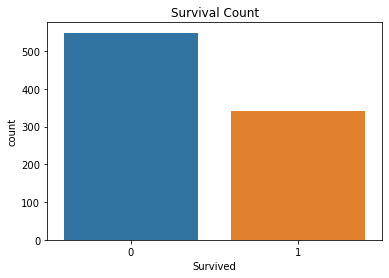

In [60]:
sns.countplot('Survived', data = train_data).set_title('Survival Count')

Let us check with the gender and Pclass for the survival count.  

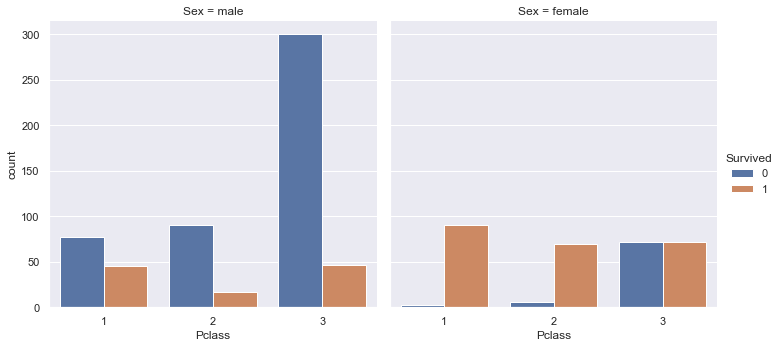

In [64]:
sns.set(style="darkgrid")
sns.catplot(x='Pclass', hue='Survived', col='Sex', data=train_data, kind='count' )

It seems that around 300 male passengers on third class died in the disaster. we can try to exclude this third class male passenger and make the data balance. 

In [77]:
train_data[train_data["Sex"]=='male'][train_data['Pclass']==3][train_data['Survived']==0]
# These are male passenger that was in third class that did not survived

PassengerId  Survived  Pclass                            Name   Sex  \
0              1         0       3         Braund, Mr. Owen Harris  male   
4              5         0       3        Allen, Mr. William Henry  male   
5              6         0       3                Moran, Mr. James  male   
7              8         0       3  Palsson, Master. Gosta Leonard  male   
12            13         0       3  Saundercock, Mr. William Henry  male   
..           ...       ...     ...                             ...   ...   
877          878         0       3            Petroff, Mr. Nedelio  male   
878          879         0       3              Laleff, Mr. Kristo  male   
881          882         0       3              Markun, Mr. Johann  male   
884          885         0       3          Sutehall, Mr. Henry Jr  male   
890          891         0       3             Dooley, Mr. Patrick  male   

      Age  SibSp  Parch           Ticket     Fare Cabin Embarked  
0    22.0      1      0        A/5 21171   7.2500   NaN        S  
4    35.0      0      0           373450   8.0500   NaN        S  
5     NaN      0      0           330877   8.4583   NaN        Q  
7     2.0      3      1           349909  21.0750   NaN        S  
12   20.0      0      0        A/5. 2151   8.0500   NaN        S  
..    ...    ...    ...              ...      ...   ...      ...  
877  19.0      0      0           349212   7.8958   NaN        S  
878   NaN      0      0           349217   7.8958   NaN        S  
881  33.0      0      0           349257   7.8958   NaN        S  
884  25.0      0      0  SOTON/OQ 392076   7.0500   NaN        S  
890  32.0      0      0           370376   7.7500   NaN        Q  

[300 rows x 12 columns]

We will exclude 207 of above data as this count makes the data imbalance (549-342) 

In [86]:
exclude_data = train_data[train_data["Sex"]=='male'][train_data['Pclass']==3][train_data['Survived']==0][:207] # simple drop data
train_data_balance =  train_data.drop(exclude_data.index)

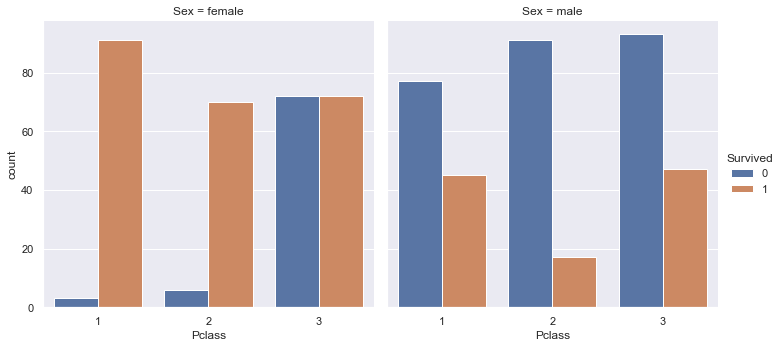

In [88]:
sns.catplot(x='Pclass', hue='Survived', col='Sex', data=train_data_balance, kind='count' )

In [89]:
train_data_balance.Survived.value_counts()

1    342
0    342
Name: Survived, dtype: int64

Now, we have a little bit of balance data. 

In [108]:
# 1. Get the features needed and assigned to X and y.
train_nmf = train_data_balance.loc[:, ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]
y = train_nmf['Survived']
train_nmf = train_nmf.drop('Survived', axis='columns')

column_trans = make_column_transformer((OneHotEncoder(), ['Sex']), remainder='passthrough')
X = column_trans.fit_transform(train_nmf)

# -------- #

#2. get the test data, X_test
med = test_data.groupby(['SibSp', 'Parch'])['Age'].transform('median')
test_data.Fare = test_data.Fare.fillna(med)
test_data.isna().sum()

X_test = test_data.loc[:,['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare']]

# 3. Let us try to fit into classifier
clf_boost = GradientBoostingClassifier()
clf_boost.fit(X, y)
predictions = clf_boost.predict(column_trans.fit_transform(X_test))

cross_val_score(clf_boost, X, y, cv=5, scoring='accuracy')

array([0.70072993, 0.73722628, 0.78832117, 0.72262774, 0.78676471])

It seems that the accuracy does not improve, let us try with other ML.

In [109]:
from sklearn.ensemble import RandomForestClassifier

clf_boost = RandomForestClassifier(max_depth=10, max_features=2)
clf_boost.fit(X, y)
predictions = clf_boost.predict(column_trans.fit_transform(X_test))

cross_val_score(clf_boost, X, y, cv=5, scoring='accuracy')

array([0.68613139, 0.73722628, 0.79562044, 0.67883212, 0.78676471])

In [112]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

clf_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
clf_boost.fit(X, y)
predictions = clf_boost.predict(column_trans.fit_transform(X_test))

cross_val_score(clf_boost, X, y, cv=5, scoring='accuracy')

array([0.60583942, 0.67883212, 0.72262774, 0.75912409, 0.79411765])